# 实验一：基于前馈神经网络的回归任务设计

## 0. 准备工作

导入所需要的包，使用 PyTorch 框架。

In [48]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler, Dataset, TensorDataset
from torchsummary import summary
from datetime import datetime
from functools import wraps
import torch.optim as optim
import matplotlib.pyplot as plt

# 设置 matplotlib 作图参数
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 该语句解决图像中的 “-” 负号的乱码问题

定义计时函数，设计成装饰器。

In [49]:
def timer(func):
    """计时函数

    Args:
        func (Any): 待计时的函数

    Returns:
        Any: 计算结果
    """

    @wraps(func)
    def wrap(*args, **kwargs):
        start_time = datetime.now()
        result = func(*args, **kwargs)
        end_time = datetime.now()
        h, remainder = divmod((end_time - start_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        print(f"\n{func.__name__} time: {h}:{m}:{s}")
        return result

    return wrap

定义模型参数设置函数，方便快速修改模型。

In [50]:
def set_model(model, criterion_type='SmoothL1Loss', optim_type='Adam', lr=1e-3):
    """设置模型参数

    Args:
        model (Net): 模型
        criterion_type (str, optional): 损失函数类型. 默认为 'SmoothL1Loss'.
        optim_type (str, optional): 优化器类型. 默认为 'Adam'.
        lr (float, optional): 学习率. 默认为 1e-3.

    Returns:
        criterion, optimizer
    """
    criterion = None
    optimizer = None
    if criterion_type == 'SmoothL1Loss':
        criterion = nn.SmoothL1Loss()
    elif criterion_type == 'MSELoss':
        criterion = nn.MSELoss()
    elif criterion_type == 'L1Loss':
        criterion = nn.L1Loss()

    if optim_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optim_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)

    return criterion, optimizer

设置模型保存的路径。

In [51]:
import os

SAVE_DIR = os.path.join(os.path.dirname(os.getcwd()), 'models', 'model.pth')
print("models will be saved at: ", SAVE_DIR)

models will be saved at:  /home/junyi/Projects/hust/CV-lab1/models/model.pth


## 1. 随机生成数据

在 [-10, 10] $\times$ [-10, 10] 的 2-D 平面内，以均匀分布随机生成 5000 个数据点 $(x_1, x_2)$。令 $f(x_1, x_2) = x_1^2 + x_1x_2 + x_2^2$。

In [52]:
num_points = 5000
# 固定随机种子，保证结果的可重复性
SEED_NUM = 0
random.seed(SEED_NUM)
np.random.seed(SEED_NUM)
torch.manual_seed(SEED_NUM)
# 生成数据
x = np.random.uniform(-10, 10, (num_points, 2))
x1, x2 = x[:, 0], x[:, 1]
y = x1 ** 2 + x1 * x2 + x2 ** 2
print(f"shape of x: {x.shape}\nshape of y: {y.shape}")

shape of x: (5000, 2)
shape of y: (5000,)


在随机生成的数据点中，随机抽取 90% 用于训练，剩下的 10% 用于测试。

In [53]:
# 生成索引
indices = np.random.permutation(num_points)
num_train = int(0.9 * num_points)
indice_train, indice_val = indices[:num_train], indices[num_train:]
# 划分数据
x_train = x[indice_train, :]
y_train = y[indice_train]
x_val = x[indice_val]
y_val = y[indice_val]
print(f"x_train: {x_train.shape}\ny_train: {y_train.shape}\nx_val:{x_val.shape}\ny_val: {y_val.shape}")

x_train: (4500, 2)
y_train: (4500,)
x_val:(500, 2)
y_val: (500,)


自定义数据集，生成 DataLoader。

In [54]:
dst_train = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
dst_val = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))
batch_size = 16  # 设置 batch 大小
loader_train = DataLoader(dst_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dst_val, batch_size=batch_size, shuffle=True)

## 2. 定义训练函数

In [55]:
@timer
def train(model: nn.Module,
          criterion,
          optimizer,
          lr_scheduler,
          loader_train: DataLoader,
          loader_val: DataLoader,
          epochs: int = 1,
          verbose: bool = True,
          save_model: bool = False,
          print_every: int = 30):
    """训练模型

    Args:
        model (nn.Module): 待训练的模型
        criterion (_type_): 损失函数
        optimizer (_type_): 优化器
        lr_scheduler (_type_): 学习率动态调整方案
        loader_train (DataLoader): 训练数据集
        loader_val (DataLoader): 验证数据集
        epochs (int, optional): epoch 大小. 默认为 1.
        verbose (bool, optional): 是否输出详细信息. 默认为 True.
        save_model (bool, optional): 是否保存训练好的模型. 默认为 False.
        print_every (int, optional): 控制输出 train loss 的频率. 默认为 30.

    Returns:
        Nothing. 仅输出模型训练过程中的 train loss 和 val loss.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loss_history, val_loss_history = [], []
    model = model.to(device=device)  # 将模型参数移动到 CPU/GPU 上
    dtype = torch.float32

    best_loss = float('inf')
    best_model = None

    for e in range(epochs):
        train_loss = 0
        for t, (x, y) in enumerate(loader_train):
            model.train()  # 模型设置为训练状态
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)

            preds = model(x).squeeze()
            # 根据预先定义的损失函数计算 loss
            loss = criterion(preds, y)

            # 将优化器的梯度置零
            optimizer.zero_grad()
            # 将 loss 反向传播回网络
            loss.backward()
            # 使用优化器更新模型参数
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(loader_train)
        train_loss_history.append(train_loss)
        lr_scheduler.step(train_loss)

        val_loss = 0
        model.eval()  # 模型设置为验证状态
        for t, (x, y) in enumerate(loader_val):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype)
            preds = model(x).squeeze()
            loss = criterion(preds, y)

            val_loss += loss.item()

        val_loss /= len(loader_val)
        val_loss_history.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model  # 保存效果最好的模型

        if verbose:
            print(f"Epoch {e + 1} / {epochs}\ttrain_loss = {train_loss:.4f}, val_loss = {val_loss:.4f}")

    if save_model:
        torch.save(best_model, SAVE_DIR)
        if verbose:
            print("best model saved at: ", SAVE_DIR)

    return train_loss_history, val_loss_history

## 3. 定义模型、损失函数和优化器

首先定义网络结构。继承自 nn.Module。

整体结构：input -> Linear -> Active -> (Linear -> Active ->) Linear -> output

In [56]:
class Net(nn.Module):
    def __init__(self, hidden_layers, activation_func):
        depth = len(hidden_layers)
        assert depth >= 1  # 检查是否至少有一个隐藏层
        super().__init__()
        hidden_layers.insert(0, 2)  # 输入数据为 2-D

        self.layers = nn.ModuleList([])
        for i in range(depth):
            self.layers.append(
                nn.Linear(hidden_layers[i], hidden_layers[i + 1])
            )

        self.output = nn.Linear(hidden_layers[-1], 1)
        self.activate = activation_func

    def forward(self, x):
        for layer in self.layers:
            x = self.activate(layer(x))
        return self.output(x)

定义损失函数、优化器等，实例化模型。

In [57]:
model = Net(hidden_layers=[256], activation_func=nn.ReLU())
# criterion = nn.SmoothL1Loss()
# optimizer = optim.Adam(model.parameters())
criterion, optimizer = set_model(model)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

检查网络结构。

In [58]:
summary(model.to('cuda'), (32, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 256]             768
              ReLU-2              [-1, 32, 256]               0
            Linear-3                [-1, 32, 1]             257
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.00
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


## 4. 训练模型

In [59]:
train_loss_history, val_loss_history = train(model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
                                             epochs=100, save_model=True)

Epoch 1 / 100	train_loss = 30.0412, val_loss = 15.8135
Epoch 2 / 100	train_loss = 14.9803, val_loss = 13.6634
Epoch 3 / 100	train_loss = 12.8388, val_loss = 11.5966
Epoch 4 / 100	train_loss = 10.9211, val_loss = 9.8949
Epoch 5 / 100	train_loss = 9.0453, val_loss = 8.0893
Epoch 6 / 100	train_loss = 7.6067, val_loss = 6.8040
Epoch 7 / 100	train_loss = 6.6298, val_loss = 6.2156
Epoch 8 / 100	train_loss = 6.0334, val_loss = 5.6409
Epoch 9 / 100	train_loss = 5.5434, val_loss = 5.3928
Epoch 10 / 100	train_loss = 5.1551, val_loss = 4.8714
Epoch 11 / 100	train_loss = 4.7908, val_loss = 4.7195
Epoch 12 / 100	train_loss = 4.4669, val_loss = 4.3124
Epoch 13 / 100	train_loss = 4.1468, val_loss = 3.9059
Epoch 14 / 100	train_loss = 3.8119, val_loss = 3.6148
Epoch 15 / 100	train_loss = 3.4638, val_loss = 3.3664
Epoch 16 / 100	train_loss = 3.1707, val_loss = 2.8684
Epoch 17 / 100	train_loss = 2.8287, val_loss = 2.4616
Epoch 18 / 100	train_loss = 2.4991, val_loss = 2.1537
Epoch 19 / 100	train_loss = 2.

## 5. 可视化训练和验证损失

画出训练和验证的损失曲线。

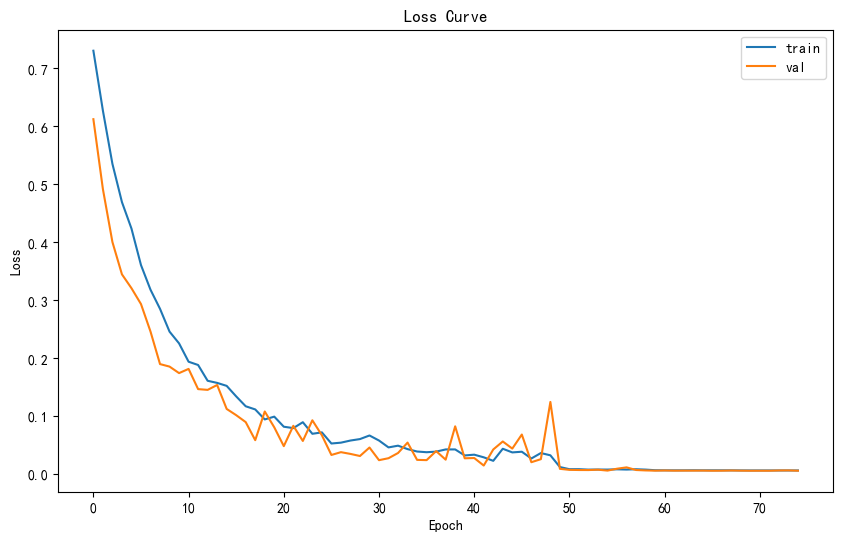

In [60]:
plt.figure(figsize=(10, 6))
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss_history[25:], '-', label='train')
plt.plot(val_loss_history[25:], '-', label='val')
plt.legend()
plt.show()

绘制预测结果与真实结果之间的散点图。

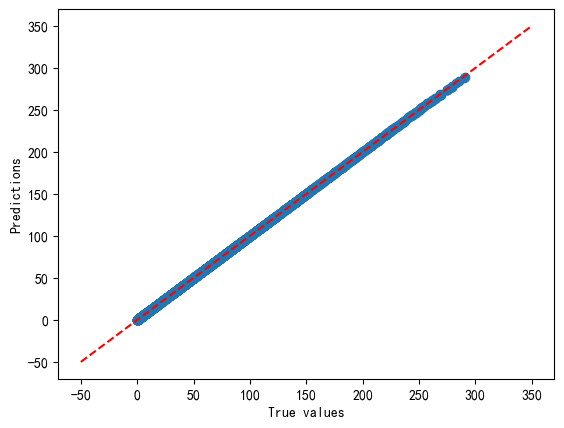

In [61]:
model.eval()  # 将模型置为验证模式
with torch.no_grad():
    x_new = torch.from_numpy(x)
    x_new = x_new.to(device='cuda', dtype=torch.float32)
    pred = model(x_new).squeeze().cpu()

fig, ax = plt.subplots()
ax.scatter(y, pred.numpy())
ax.plot([-50, 350], [-50, 350], "r--")
ax.set_xlabel("True values")
ax.set_ylabel("Predictions")
plt.show()

## 6. 尝试不同的网络层数

尝试改变网络中隐藏层的数量，比较拥有不同隐藏层的网络的性能。

创建 5 个模型，分别具有 2、4、8、16、32 个隐藏层，每层都具有相同的神经元数量。模型采用相同的激活函数（ReLU）、损失函数（SmoothL1Loss）、优化器等。

In [62]:
hidden_layers = [2, 4, 8, 16, 32]

model_list = [
    Net(
        hidden_layers=[16 for _ in range(i)],
        activation_func=nn.ReLU()
    ) for i in hidden_layers
]

train_loss_history_list, val_loss_history_list = [], []

for idx, model in enumerate(model_list):
    print(f"hidden_layers_{hidden_layers[idx]}")
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters())
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
    train_loss_history, val_loss_history = train(model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
                                                 epochs=10, verbose=True)
    train_loss_history_list.append(train_loss_history)
    val_loss_history_list.append(val_loss_history)
    print()

hidden_layers_2
Epoch 1 / 10	train_loss = 48.5967, val_loss = 22.7866
Epoch 2 / 10	train_loss = 18.8237, val_loss = 15.7089
Epoch 3 / 10	train_loss = 15.4464, val_loss = 14.1747
Epoch 4 / 10	train_loss = 13.6260, val_loss = 12.5826
Epoch 5 / 10	train_loss = 11.7543, val_loss = 10.5228
Epoch 6 / 10	train_loss = 10.0633, val_loss = 9.0264
Epoch 7 / 10	train_loss = 8.7245, val_loss = 8.1001
Epoch 8 / 10	train_loss = 7.7568, val_loss = 7.3703
Epoch 9 / 10	train_loss = 7.0382, val_loss = 6.4777
Epoch 10 / 10	train_loss = 6.5416, val_loss = 6.2962

train time: 0:0:5

hidden_layers_4
Epoch 1 / 10	train_loss = 36.7156, val_loss = 14.8920
Epoch 2 / 10	train_loss = 12.9001, val_loss = 9.7662
Epoch 3 / 10	train_loss = 7.5964, val_loss = 5.9421
Epoch 4 / 10	train_loss = 4.7859, val_loss = 3.7941
Epoch 5 / 10	train_loss = 3.1749, val_loss = 2.3522
Epoch 6 / 10	train_loss = 2.2698, val_loss = 1.9298
Epoch 7 / 10	train_loss = 1.8124, val_loss = 2.1014
Epoch 8 / 10	train_loss = 1.5527, val_loss = 2.08

画图比较各个模型的效果。考虑到训练时间，仅展示 loss 在 10 个 epoch 范围的变化趋势。

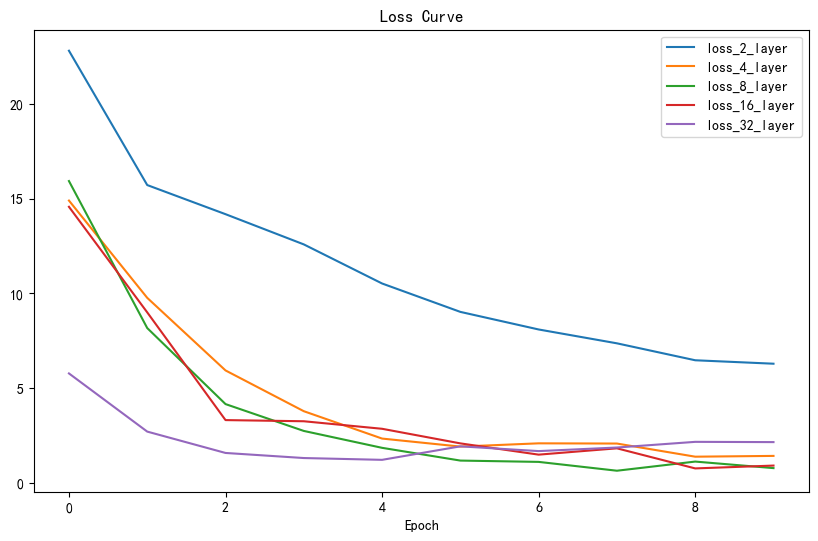

In [63]:
plt.figure(figsize=(10, 6))
plt.title('Loss Curve')
plt.xlabel('Epoch')
for idx, layer in enumerate(hidden_layers):
    plt.plot(val_loss_history_list[idx], '-', label=f"loss_{layer}_layer")
plt.legend()
plt.show()

## 7. 尝试不同的神经元数量

尝试改变网络中神经元的数量，比较拥有不同神经元数量的网络的性能。

创建 4 个模型，每个模型都只有一个隐藏层，分别具有 8、16、32、64 个神经元。模型采用相同的激活函数（ReLU）、损失函数（SmoothL1Loss）、优化器等。

In [64]:
neuron_num = [8, 16, 32, 64]

model_list = [
    Net(
        hidden_layers=[layer],
        activation_func=nn.ReLU()
    ) for layer in neuron_num
]

train_loss_history_list, val_loss_history_list = [], []
for idx, model in enumerate(model_list):
    print(f"neuron_num_{neuron_num[idx]}")
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters())
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
    train_loss_history, val_loss_history = train(model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
                                                 epochs=10, verbose=True)
    train_loss_history_list.append(train_loss_history)
    val_loss_history_list.append(val_loss_history)
    print()

neuron_num_8
Epoch 1 / 10	train_loss = 63.8567, val_loss = 56.8449
Epoch 2 / 10	train_loss = 55.7836, val_loss = 47.6211
Epoch 3 / 10	train_loss = 43.3361, val_loss = 33.9824
Epoch 4 / 10	train_loss = 31.4965, val_loss = 26.0919
Epoch 5 / 10	train_loss = 24.3555, val_loss = 21.2606
Epoch 6 / 10	train_loss = 20.1130, val_loss = 18.2583
Epoch 7 / 10	train_loss = 17.8739, val_loss = 16.8224
Epoch 8 / 10	train_loss = 16.7615, val_loss = 16.2150
Epoch 9 / 10	train_loss = 16.0721, val_loss = 15.6287
Epoch 10 / 10	train_loss = 15.5124, val_loss = 14.6824

train time: 0:0:4

neuron_num_16
Epoch 1 / 10	train_loss = 59.8307, val_loss = 49.0464
Epoch 2 / 10	train_loss = 44.7622, val_loss = 33.9256
Epoch 3 / 10	train_loss = 29.4294, val_loss = 21.5631
Epoch 4 / 10	train_loss = 20.2968, val_loss = 17.2448
Epoch 5 / 10	train_loss = 17.5074, val_loss = 16.0076
Epoch 6 / 10	train_loss = 16.4558, val_loss = 15.6145
Epoch 7 / 10	train_loss = 15.6949, val_loss = 14.6800
Epoch 8 / 10	train_loss = 15.0144,

画图比较各个模型的效果。考虑到训练时间，仅展示 loss 在 10 个 epoch 范围的变化趋势。

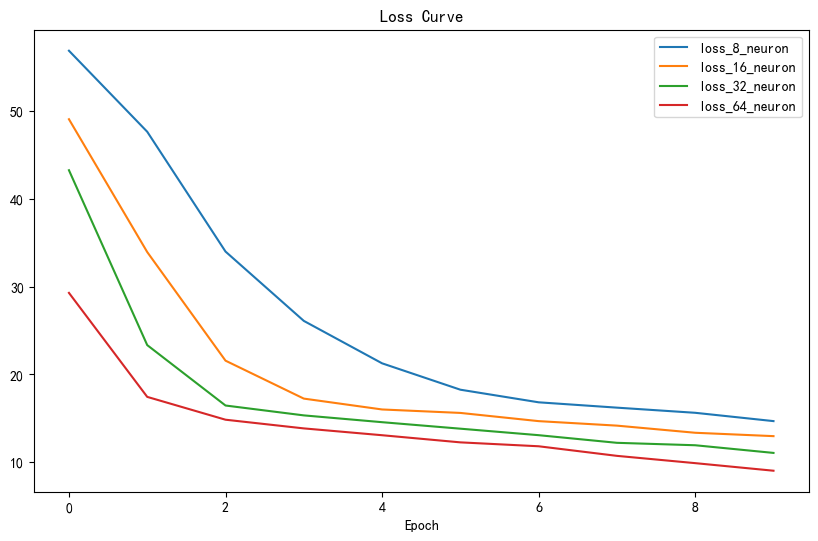

In [65]:
plt.figure(figsize=(10, 6))
plt.title('Loss Curve')
plt.xlabel('Epoch')
for idx, layer in enumerate(neuron_num):
    plt.plot(val_loss_history_list[idx], '-', label=f"loss_{layer}_neuron")
plt.legend()
plt.show()

## 8. 尝试不同的激活函数

尝试改变网络中使用的激活函数，比较模型的性能。

创建 4 个模型，分别使用 Sigmoid、ReLU、LeakyReLU 和 Tanh 作为激活函数，其他参数相同。

In [66]:
activation_type = ['Sigmoid', 'ReLU', 'LeakyReLU', 'Tanh']

model_sigmoid = Net([32], nn.Sigmoid())
model_relu = Net([32], nn.ReLU())
model_leakyrelu = Net([32], nn.LeakyReLU())
model_tanh = Net([32], nn.Tanh())

model_list = [model_sigmoid, model_relu, model_leakyrelu, model_tanh]

train_loss_history_list, val_loss_history_list = [], []
for idx, model in enumerate(model_list):
    print(f"model_{activation_type[idx]}")
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters())
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
    train_loss_history, val_loss_history = train(model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
                                                 epochs=10, verbose=True)
    train_loss_history_list.append(train_loss_history)
    val_loss_history_list.append(val_loss_history)
    print()

model_Sigmoid
Epoch 1 / 10	train_loss = 63.9946, val_loss = 58.9723
Epoch 2 / 10	train_loss = 58.7323, val_loss = 53.4742
Epoch 3 / 10	train_loss = 53.3263, val_loss = 47.1130
Epoch 4 / 10	train_loss = 48.3224, val_loss = 43.5219
Epoch 5 / 10	train_loss = 44.2922, val_loss = 41.3138
Epoch 6 / 10	train_loss = 41.5310, val_loss = 38.4721
Epoch 7 / 10	train_loss = 39.7948, val_loss = 38.0679
Epoch 8 / 10	train_loss = 38.9127, val_loss = 36.6876
Epoch 9 / 10	train_loss = 38.4177, val_loss = 36.6172
Epoch 10 / 10	train_loss = 38.1242, val_loss = 36.4822

train time: 0:0:4

model_ReLU
Epoch 1 / 10	train_loss = 58.3446, val_loss = 43.5821
Epoch 2 / 10	train_loss = 32.8647, val_loss = 22.1111
Epoch 3 / 10	train_loss = 19.6425, val_loss = 16.8804
Epoch 4 / 10	train_loss = 16.9728, val_loss = 15.3822
Epoch 5 / 10	train_loss = 15.8079, val_loss = 15.1330
Epoch 6 / 10	train_loss = 14.8586, val_loss = 13.9829
Epoch 7 / 10	train_loss = 14.0186, val_loss = 13.1162
Epoch 8 / 10	train_loss = 13.2660, v

画图比较各个模型的效果。考虑到训练时间，仅展示 loss 在 10 个 epoch 范围的变化趋势。

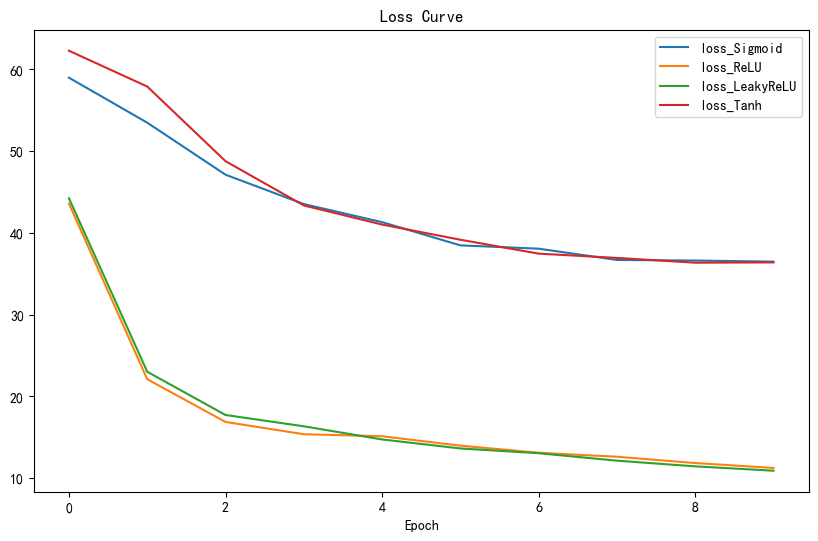

In [67]:
plt.figure(figsize=(10, 6))
plt.title('Loss Curve')
plt.xlabel('Epoch')
for idx, activation in enumerate(activation_type):
    plt.plot(val_loss_history_list[idx], '-', label=f"loss_{activation}")
plt.legend()
plt.show()